In [35]:
import numpy as np
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from parse_filenames import parse_filenames
from scipy import stats
import pickle

In [25]:
path = Path.home() / 'Desktop' / 'disk2' / 'lfp_power_spectra_dump'

In [26]:
parsed_df = parse_filenames(path)
parsed_df

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename
0,794812542,VISpm,toWhite,True,2,992.0,sessionID_794812542_area_VISpm_condition_toWhi...
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...
3,771990200,VISpm,toWhite,False,63,985.0,sessionID_771990200_area_VISpm_condition_toWhi...
4,742951821,VISpm,toBlack,True,1,NaN,sessionID_742951821_area_VISpm_condition_toBla...
...,...,...,...,...,...,...,...
144,715093703,VISp,toWhite,False,14,NaN,sessionID_715093703_area_VISp_condition_toWhit...
145,771160300,VISp,toWhite,True,29,1135.0,sessionID_771160300_area_VISp_condition_toWhit...
146,719161530,VISp,toWhite,False,17,762.0,sessionID_719161530_area_VISp_condition_toWhit...
147,761418226,VISpm,toBlack,False,74,1165.0,sessionID_761418226_area_VISpm_condition_toBla...


In [27]:
# Deleting rows without 8 conditions

for sid in parsed_df.sessionID.unique():
    if len(parsed_df[parsed_df.sessionID==sid]) != 8:
        parsed_df = parsed_df.drop(parsed_df[parsed_df.sessionID==sid].index)

In [28]:
conditions = [('VISpm', 'toWhite', True), ('VISpm', 'toBlack', True), ('VISpm', 'toWhite', False), ('VISpm', 'toBlack', False),
             ('VISp', 'toWhite', True), ('VISp', 'toBlack', True), ('VISp', 'toWhite', False), ('VISp', 'toBlack', False)]

for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
    print(condition, len(selected_df))

('VISpm', 'toWhite', True) 18
('VISpm', 'toBlack', True) 18
('VISpm', 'toWhite', False) 18
('VISpm', 'toBlack', False) 18
('VISp', 'toWhite', True) 18
('VISp', 'toBlack', True) 18
('VISp', 'toWhite', False) 18
('VISp', 'toBlack', False) 18


In [29]:
parsed_df

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...
3,771990200,VISpm,toWhite,False,63,985.0,sessionID_771990200_area_VISpm_condition_toWhi...
4,742951821,VISpm,toBlack,True,1,NaN,sessionID_742951821_area_VISpm_condition_toBla...
5,791319847,VISpm,toWhite,True,19,1047.0,sessionID_791319847_area_VISpm_condition_toWhi...
...,...,...,...,...,...,...,...
144,715093703,VISp,toWhite,False,14,NaN,sessionID_715093703_area_VISp_condition_toWhit...
145,771160300,VISp,toWhite,True,29,1135.0,sessionID_771160300_area_VISp_condition_toWhit...
146,719161530,VISp,toWhite,False,17,762.0,sessionID_719161530_area_VISp_condition_toWhit...
147,761418226,VISpm,toBlack,False,74,1165.0,sessionID_761418226_area_VISpm_condition_toBla...


## Single session power spectra

In [8]:
sid = 771160300

In [9]:
CI = 0.2

In [43]:
# pss = []

# for condition in conditions:
#     selected_df = parsed_df[(parsed_df.sessionID==sid) & (parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
#     loaded_list = np.load(path/selected_df.filename.item(), allow_pickle=True)
#     pss.append(loaded_list)

# f = pss[0][0]

In [42]:
# # One session's power spectra
# # Contents of pss[i]: [f,s1,s1_std,s1_snum,s2,s2_std,s2_snum]

# fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10))

# for i in range(4):
#     # ax[0][i].plot(f,pss[i][1] / pss[i][1].max())
#     # ax[0][i].plot(f,pss[i][2] / pss[i][1].max())
#     ax[0][i].errorbar(f, pss[i][1] / pss[i][1].max(), yerr= (CI * pss[i][2] / np.sqrt(pss[i][3])) / pss[i][1].max(), capsize=5)
#     ax[0][i].errorbar(f, pss[i][4] / pss[i][1].max(), yerr= (CI * pss[i][5] / np.sqrt(pss[i][6])) / pss[i][1].max(), capsize=5)
#     ax[0][i].set_title(f'{conditions[i][0]} {conditions[i][1]} running {conditions[i][2]}')
#     ax[0][i].set_xlim([1,10])
#     ax[0][i].legend(['before flash','after flash'])
#     ax[0][i].set_xlabel('frequency Hz')
#     ax[0][i].set_ylabel('normalised power V**2')
    
# for i in range(4):
#     # ax[1][i].plot(f,pss[4+i][1] / pss[4+i][1].max())
#     # ax[1][i].plot(f,pss[4+i][2] / pss[4+i][1].max())
#     ax[1][i].errorbar(f, pss[4+i][1] / pss[4+i][1].max(), yerr= (CI * pss[4+i][2] / np.sqrt(pss[4+i][3])) / pss[4+i][1].max(), capsize=5)
#     ax[1][i].errorbar(f, pss[4+i][4] / pss[4+i][1].max(), yerr= (CI * pss[4+i][5] / np.sqrt(pss[4+i][6])) / pss[4+i][1].max(), capsize=5)
#     ax[1][i].set_title(f'{conditions[4+i][0]} {conditions[4+i][1]} running {conditions[4+i][2]}')
#     ax[1][i].set_xlim([1,10])
#     ax[1][i].legend(['before flash','after flash'])
#     ax[1][i].set_xlabel('frequency Hz')
#     ax[1][i].set_ylabel('normalised power V**2')
    
# plt.tight_layout()
# plt.show()

## Session averages

In [30]:
def get_iqr(data):
    iqrs = []

    for t in range(data.shape[1]):
        iqr = stats.iqr(data[:,t])
        iqrs.append(iqr)
        
    return np.array(iqrs)

In [31]:
parsed_df['f'] = ''
parsed_df['before_median'] = ''
parsed_df['before_iqr'] = ''
parsed_df['after_median'] = ''
parsed_df['after_iqr'] = ''

In [ ]:
# with open(Path.home() / 'Desktop' / 'disk2' / 'lfp_ps_parsed_df.pkl', 'rb') as f: parsed_df = pickle.load(f)

In [32]:
for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
    for cols in selected_df.iterrows():
        f, s1, s2 = np.load(path / cols[1].filename, allow_pickle=True)
        # Saving time data, median time series and iqr (variability measure) time series for eahc condition-session entry
        for i in selected_df.index: 
            parsed_df.at[i, 'f'] = f
            parsed_df.at[i, 'before_median'] = np.median(s1, axis=0)
            parsed_df.at[i, 'before_iqr'] = get_iqr(s1)
            parsed_df.at[i, 'after_median'] = np.median(s2, axis=0)
            parsed_df.at[i, 'after_iqr'] = get_iqr(s2)

In [38]:
parsed_df.head()

,sessionID,area,condition,running,flashesAveragedOver,micronsElectrodeDepth,filename,f,before_median,before_iqr,after_median,after_iqr
1,742951821,VISp,toWhite,True,2,NaN,sessionID_742951821_area_VISp_condition_toWhit...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[3.178569e-11, 2.1369405e-10, 1.9370018e-10, 1...","[8.551295001962833e-11, 3.4963082429229075e-10...","[3.179759e-11, 2.3460708e-10, 2.5096994e-10, 1...","[8.003767527214878e-11, 2.881923449882251e-10,..."
2,771990200,VISp,toBlack,True,14,1039.0,sessionID_771990200_area_VISp_condition_toBlac...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[1.4235671e-13, 7.485075e-12, 1.6694935e-11, 2...","[1.636120080562522e-11, 1.0292168332870334e-10...","[1.3455732e-15, 5.9051744e-12, 3.621034e-11, 3...","[1.4929407753449553e-11, 7.602900600755914e-11..."
3,771990200,VISpm,toWhite,False,63,985.0,sessionID_771990200_area_VISpm_condition_toWhi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[7.255757e-11, 3.9238301e-10, 3.9782055e-10, 5...","[1.7075865634680332e-10, 1.0221461524406728e-0...","[4.5507598e-11, 4.043209e-10, 3.4686626e-10, 3...","[1.7669778357501387e-10, 8.608979449459264e-10..."
4,742951821,VISpm,toBlack,True,1,NaN,sessionID_742951821_area_VISpm_condition_toBla...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[1.6806804e-11, 9.991789e-11, 1.4092061e-10, 1...","[4.592018367118034e-11, 1.4114870383608036e-10...","[1.1261204e-11, 1.1942937e-10, 1.3759224e-10, ...","[3.779035721504509e-11, 1.3518591801542357e-10..."
5,791319847,VISpm,toWhite,True,19,1047.0,sessionID_791319847_area_VISpm_condition_toWhi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.4752822811195327e-13, 1.5234972138011837e-1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.862496376743572e-12, 2.256259155203333e-11,..."


In [39]:
# with open(Path.home() / 'Desktop' / 'disk2' / 'lfp_ps_parsed_df.pkl', "wb") as f:
#     pickle.dump(parsed_df, f)

## Weighted average of power spectra

In [40]:
weighted_average_ps1 = []
weighted_average_ps2 = []

for condition in conditions:
    selected_df = parsed_df[(parsed_df.area==condition[0]) & (parsed_df.condition==condition[1]) & (parsed_df.running==condition[2])]
    N = selected_df.flashesAveragedOver.sum()
    
    collected_weighted_median_ps1 = []
    collected_weighted_iqr_ps1 = []
    collected_weighted_median_ps2 = []
    collected_weighted_iqr_ps2 = []
    
    for cols in selected_df.iterrows():
        f,ps1,ps1_iqr,ps2,ps2_iqr = cols[1]['f'],cols[1]['before_median'],cols[1]['before_iqr'],cols[1]['after_median'],cols[1]['after_iqr']
        
        collected_weighted_median_ps1.append((cols[1].flashesAveragedOver / N) * ps1)
        collected_weighted_iqr_ps1.append((cols[1].flashesAveragedOver / N) * ps1_iqr)
        collected_weighted_median_ps2.append((cols[1].flashesAveragedOver / N) * ps2)
        collected_weighted_iqr_ps2.append((cols[1].flashesAveragedOver / N) * ps2_iqr)
        
    collected_weighted_median_ps1 = np.array(collected_weighted_median_ps1)
    collected_weighted_iqr_ps1 = np.array(collected_weighted_iqr_ps1)
    collected_weighted_median_ps2 = np.array(collected_weighted_median_ps2)
    collected_weighted_iqr_ps2 = np.array(collected_weighted_iqr_ps2)
        
    weighted_average_ps1.append([f, collected_weighted_median_ps1.sum(axis=0), collected_weighted_iqr_ps1.sum(axis=0)]) 
    weighted_average_ps2.append([f, collected_weighted_median_ps2.sum(axis=0), collected_weighted_iqr_ps2.sum(axis=0)])

/home/ikharitonov/anaconda3/envs/allendata/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/ikharitonov/anaconda3/envs/allendata/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ikharitonov/anaconda3/envs/allendata/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/ikharitonov/anaconda3/envs/allendata/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


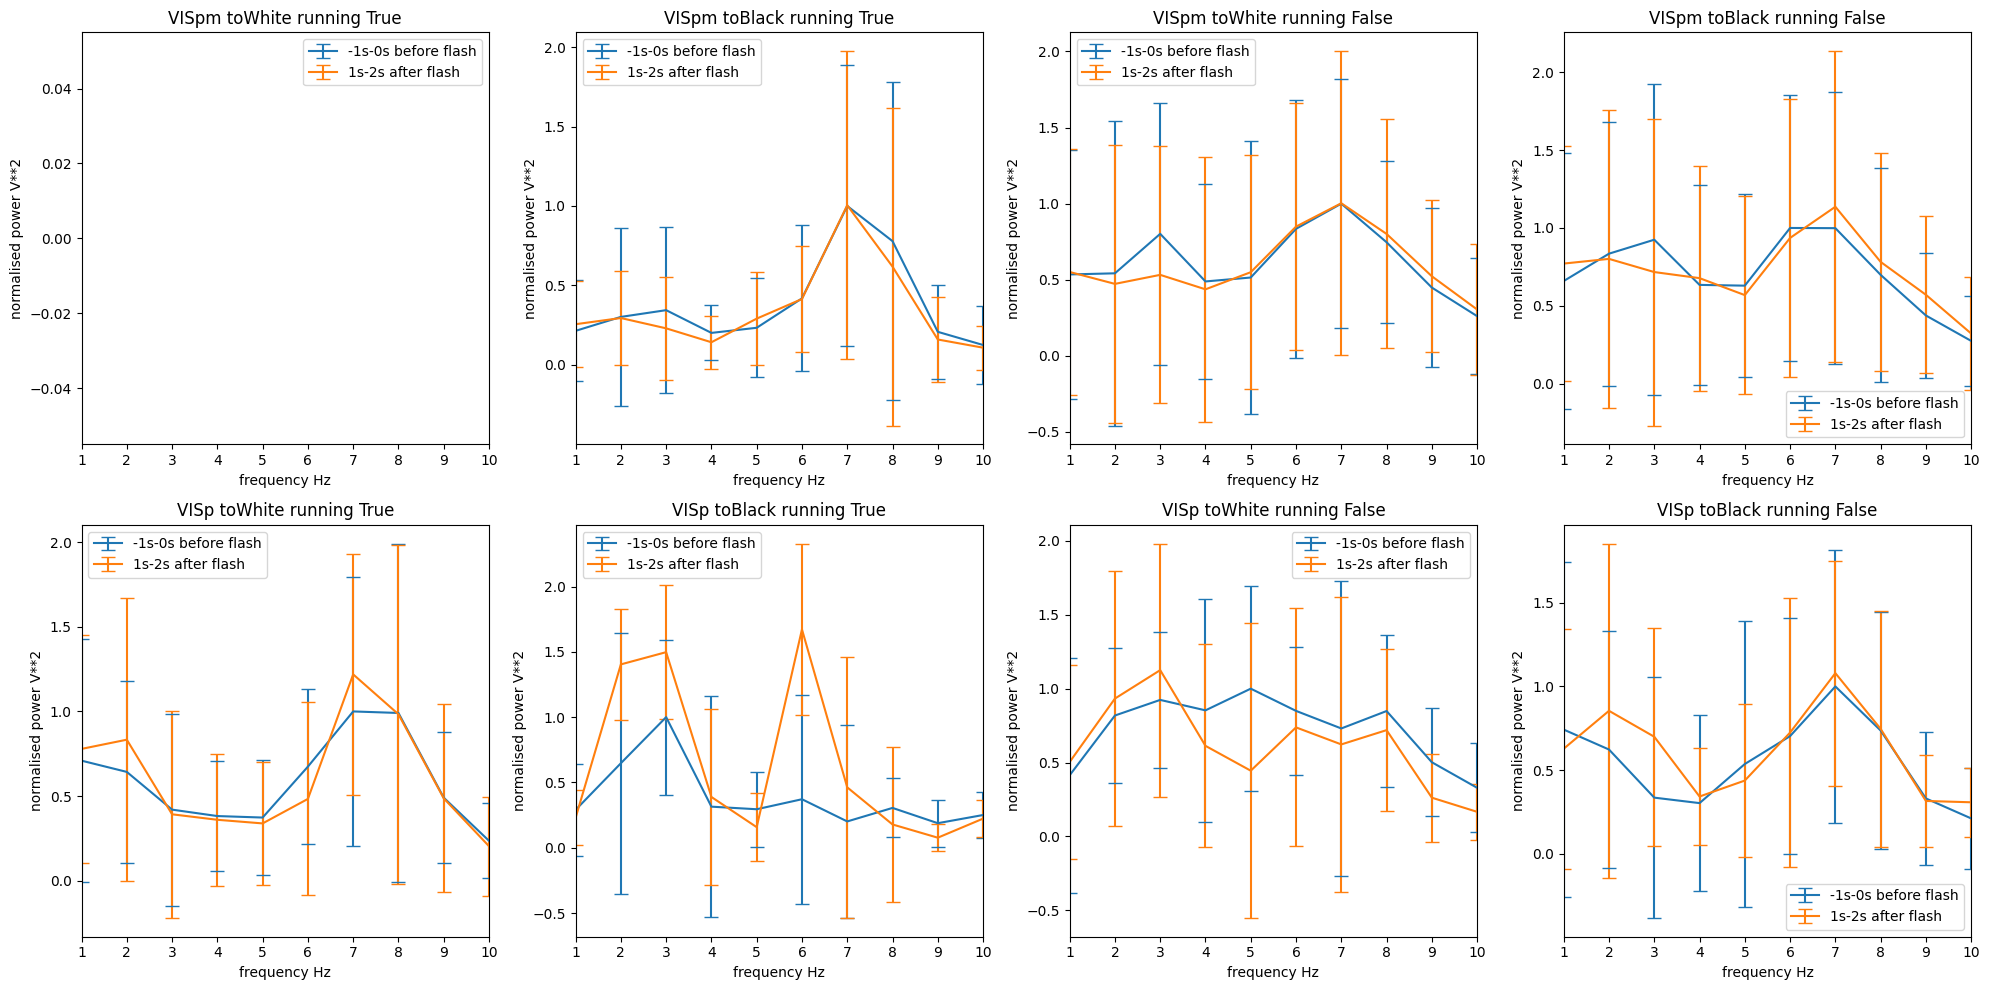

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10))

for i in range(4):
    # ax[0][i].plot(f,weighted_average_ps1[i][1] / weighted_average_ps1[i][1].max())
    ax[0][i].errorbar(f,weighted_average_ps1[i][1] / weighted_average_ps1[i][1].max(), yerr=weighted_average_ps1[i][2] / weighted_average_ps1[i][2].max(),capsize=5)
    # ax[0][i].plot(f,weighted_average_ps2[i][1] / weighted_average_ps1[i][1].max())
    ax[0][i].errorbar(f,weighted_average_ps2[i][1] / weighted_average_ps1[i][1].max(), yerr=weighted_average_ps2[i][2] / weighted_average_ps2[i][2].max(),capsize=5)
    ax[0][i].set_title(f'{conditions[i][0]} {conditions[i][1]} running {conditions[i][2]}')
    ax[0][i].legend(['-1s-0s before flash','1s-2s after flash'])
    ax[0][i].set_xlabel('frequency Hz')
    ax[0][i].set_ylabel('normalised power V**2')
    ax[0][i].set_xlim([1,10])
    
for i in range(4):
    # ax[1][i].plot(f,weighted_average_ps1[4+i][1] / weighted_average_ps1[4+i][1].max())
    ax[1][i].errorbar(f,weighted_average_ps1[4+i][1] / weighted_average_ps1[4+i][1].max(), yerr=weighted_average_ps1[4+i][2] / weighted_average_ps1[4+i][2].max(),capsize=5)
    # ax[1][i].plot(f,weighted_average_ps2[4+i][1] / weighted_average_ps1[4+i][1].max())
    ax[1][i].errorbar(f,weighted_average_ps2[4+i][1] / weighted_average_ps1[4+i][1].max(), yerr=weighted_average_ps2[4+i][2] / weighted_average_ps2[4+i][2].max(),capsize=5)
    ax[1][i].set_title(f'{conditions[4+i][0]} {conditions[4+i][1]} running {conditions[4+i][2]}')
    ax[1][i].legend(['-1s-0s before flash','1s-2s after flash'])
    ax[1][i].set_xlabel('frequency Hz')
    ax[1][i].set_ylabel('normalised power V**2')
    ax[1][i].set_xlim([1,10])
    
plt.tight_layout()
plt.show()